In [1]:
import filterpy

In [2]:
import numpy as np
from scipy.linalg import cholesky
from filterpy.kalman import unscented_transform
from filterpy.stats import logpdf
from filterpy.common import pretty_str


class RLS:
    '''RLS filter'''
    def __init__(self, sysorder):
        self.lamda = 1
        self.delta = 1
        self.P = self.delta * np.eye(sysorder)
        self.theta = np.zeros([sysorder, 1])

    def update(self, K, e, phi):
        self.P = (self.P - np.matmul(np.matmul(K, phi), self.P)) / self.lamda
        self.theta = self.theta + (K * e)

    def getResult(self, phi, d):
        y = np.matmul(phi, self.theta)
        K = np.matmul(self.P, np.transpose(phi)) / (np.matmul(np.matmul(phi, self.P), np.transpose(phi)) + self.lamda)
        e = d - y;
        self.update(K, e, phi)

        return [y[0, 0], self.theta]

In [3]:
import numpy as np
import csv
%matplotlib inline
import pandas as pd

In [4]:
f = open("ocv.txt", 'r')
ocv_t = []
ocv = []
temp = f.readline()
ocv_t = temp.split()
f.close()

for i in ocv_t:
    ocv.append(float(i))

In [35]:
import os
path = ".\DischargingData\Discharging\Real"
temp_range = ["\T10","\T15","\T20","\T25","\T30","\T35","\T40","\T45"]
temp_length = len(temp_range)
for everyt in range(temp_length) : #온도별 모든파일  
    file_list = os.listdir(path+temp_range[everyt])
    file_list_csv = [file for file in file_list if file.endswith(".csv")]
    file_length = len(file_list_csv)
    
    
    EDV = 3.0
    for k in range(file_length) : #해당온도에서 모든파일
        data = open(path+temp_range[everyt]+'\\'+file_list_csv[k], 'r')
        rdr = csv.reader(data)
        data2 = open(path+temp_range[everyt]+'\\'+file_list_csv[k], 'r')
        rdr2 = csv.reader(data2)
        f = open(path+'\\filter_result'+'\\f_result'+file_list_csv[k], 'w', newline='')
        wr = csv.writer(f)
        #--- initialize
        n = 0
        j = 0
        time_accum = 0.00001
        
        if "0cycle" in file_list_csv[k]:
            cycle = 0
        if "100cycle" in file_list_csv[k]:
            cycle = 100
        if "200cycle" in file_list_csv[k] :
            cycle = 200
            
        if "T10" in file_list_csv[k] :
            temperature = 10
        if "T15" in file_list_csv[k] :
            temperature = 15
        if "T20" in file_list_csv[k] :
            temperature = 20
        if "T25" in file_list_csv[k] :
            temperature = 25
        if "T30" in file_list_csv[k] :
            temperature = 30
        if "T35" in file_list_csv[k] :
            temperature = 35
        if "T40" in file_list_csv[k] :
            temperature = 40
        if "T45" in file_list_csv[k] :
            temperature = 45
            
        
        # 각 온도별 파일의 full cap 을 알기위해
        for line in rdr :
            if (j >= 1) and float(line[5]) >= 3.0  :
                fullCap1 = abs(float(line[3]))
            j = j+1
        print(fullCap1)
        
        soc1 = [1]
        sysorder = 6
        t = []
        v1 = []
        I1 = []
        remainCap1 = [fullCap1]
        #--- make filters
        RLSFilter1 = RLS(sysorder)
        
        
        isFirst = 1
        i = 1
        for line in rdr2:
            if isFirst == 1:
                isFirst = 0
                continue
            I_tmp = float(line[4])# 파일에서 전류값 읽기
            Ih_tmp = float(line[3]) # 파일에서 전류Xt  읽기
            v_tmp = float(line[5])# 파일에서 전압값 일기
            t_tmp = float(line[2])# 파일에서 시간 읽기

            if v_tmp < EDV : 
                #print(remainCap1[n-1])
                break

            t.append(t_tmp)
            v1.append(v_tmp)
            I1.append(I_tmp/1000)

            delta_t = (t[n] - t[n - 1]) / 3600 #초를 시간으로
            if n == 0 :
                category = ["Amp-hr", "Amps", "Voltage","Ro", "Rp","Cp","Rdiff","Cdiff","SOC","Cycle","Temperature"]
                wr.writerow(category)
               
            if n < 3:
                if n > 0:
                    remainCap1.append(remainCap1[n - 1])
                    soc1.append(remainCap1[n] / fullCap1)
                n = n + 1
                continue
    
            #remainCap1.append(remainCap1[n - 1] + (delta_t * I1[n - 1]))
            #soc1.append(remainCap1[-1] / fullCap1)
            remainCap1.append(fullCap1+Ih_tmp)
            soc1.append(remainCap1[n] / fullCap1)
            
            
            if(soc1[-1] < 1) :
                ocv1 = ocv[int((soc1[-1])*1000)]
            else :
                ocv1 = ocv[1000]
            
    
            phi1 = np.array([[ocv1, v1[n-1], v1[n-2], I1[n], I1[n-1], I1[n-2]]])


            # RLS Filtering
            [y1, theta1] = RLSFilter1.getResult(phi1, v1[n])
            # y1 이 추정된 전압
            # theta 배터리 파라미터
            
            if I_tmp != 0 : #I_tmp가 0이면 불필요한 데이터
            
                # available SOC Calculation
                Rs1 = abs((-theta1[3] - theta1[4] - theta1[5]) / theta1[0])

                # ret.append([t[-1], ocv1,y1, v1[-1], I1[-1], Rs1[0]])
                a = ( (-1*theta1[3][0])+theta1[4][0]-theta1[5][0]) /(1 + theta1[1][0] - theta1[2][0]) # a= Ro
                b = (1 + theta1[2][0] + np.sqrt(theta1[2][0]**2 + 3*theta1[2][0] - theta1[1][0])) / 2*theta1[0][0]
                r = (1 + theta1[2][0] - np.sqrt(theta1[2][0]**2 + 3*theta1[2][0] - theta1[1][0])) / 2*theta1[0][0]
                w = (theta1[5][0]-theta1[3][0]) / theta1[0][0]
                z = (-theta1[3][0] -theta1[4][0] - theta1[5][0])/theta1[0][0]
                Rp = (w-a*b-a*r-z*b+a*b)/(r-b)
                Rdiff = (z-a)-Rp
                Cp = b/Rp
                Cdiff = r/Rdiff
                line.append(a)
                line.append(Rp)
                line.append(Cp)
                line.append(Rdiff)
                line.append(Cdiff)
                wr.writerow([Ih_tmp, I_tmp, v_tmp, a, Rp, Cp, Rdiff, Cdiff, soc1[n], cycle, temperature])
            n = n + 1
        f.close()
        data.close()
        data2.close()
    




4.31823
4.32384
4.31657
4.32153
4.15026
4.18805
4.23384
4.0753
4.02568
4.18917
4.08306
4.14318
4.36425
4.3094
4.37367
4.3188
4.13873
4.18826
4.19099
4.22043
4.04525
4.07906
4.0512
4.0806
4.39201
4.35341
4.39437
4.28453
4.26491
4.12598
4.15871
4.2852
4.27279
4.12795
4.16435
4.4181
4.35068
4.4217
4.3581
4.35129
4.29907
4.35259
4.2986
4.18624
4.21647
4.40287
4.40265
4.4047
4.41406
4.29179
4.30897
4.29041
4.31828
4.23196
4.1867
4.23981
4.19501
4.48619
4.45167
4.47645
4.44169
4.33546
4.28035
4.35443
4.30182
4.47718
4.45682
4.4971
4.45922
4.52994
4.49728
4.46838
4.25601
4.2022
4.22733
4.19051
4.5301
4.4911
4.53192
4.49184
4.5611
4.56614
4.56193
4.56807
4.27914
4.29551
4.26887
4.28564
4.47104
4.45158
4.47223
4.45432
4.47075
4.43689
4.47169
4.43631
4.39312
4.34244
4.36662
4.3183
4.54277
4.54971
4.54493
4.55058
4.57187
4.59987
4.57187
4.59945
4.27265
4.30871
4.46906
4.47562
4.49411
4.47394
4.47001
4.47854
4.49473
4.47561
4.46423
4.47054
4.46444
4.47052
4.48403
4.46632
4.48353
4.46842
4.42601
4.

In [34]:
f.close()
data.close()
data2.close()

In [18]:
import os
path = ".\DischargingData\Discharging\Real"
temp_range = ["\T10","\T15","\T20","\T25","\T30","\T35","\T40","\T45"]
temp_length = len(temp_range)
for everyt in range(6,7) : #온도별 모든파일  
    file_list = os.listdir(path+temp_range[everyt])
    file_list_csv = [file for file in file_list if file.endswith(".csv")]
    file_length = len(file_list_csv)
    
    
    EDV = 3.0
    for k in range(0,1) : #해당온도에서 모든파일
        data = open(path+temp_range[everyt]+'\\'+file_list_csv[k], 'r')
        rdr = csv.reader(data)
        data2 = open(path+temp_range[everyt]+'\\'+file_list_csv[k], 'r')
        rdr2 = csv.reader(data2)
        data3 = open(path+temp_range[everyt]+'\\'+file_list_csv[k], 'r')
        rdr3 = csv.reader(data3)
        f = open(path+'\\filter_result'+temp_range[everyt]+'\\filter_result'+file_list_csv[k], 'w', newline='')
        wr = csv.writer(f)
        #--- initialize
        n = 0
        j = 1
        time_accum = 0.00001

        # 각 온도별 파일의 full cap 을 알기위해
        row_count = sum(1 for row in rdr)
        for line in rdr2 :
            if j == row_count :
                fullCap1 = abs(float(line[3]))
            j = j+1
        print(fullCap1)
        
        soc2 = [1]
        sysorder = 6
        t = []
        v2 = []
        I1 = []
        estimatedV = []
        remainCap1 = [fullCap1]
        ret = []
        #--- make filters
        RLSFilter1 = RLS(sysorder)
        
        
        isFirst = 1
        i = 1
        for line in rdr3:
            if isFirst == 1:
                isFirst = 0
                continue
            I_tmp = float(line[4])# 파일에서 전류값 읽기
            Ih_tmp = float(line[3]) # 파일에서 전류Xt  읽기
            v_tmp = float(line[5])# 파일에서 전압값 일기
            t_tmp = float(line[2])# 파일에서 시간 읽기

            if v_tmp <= EDV : 
                #print(remainCap1[n-1])
                break

            t.append(t_tmp)
            v2.append(v_tmp)
            I1.append(I_tmp/1000)

            delta_t = (t[n] - t[n - 1]) / 3600 #초를 시간으로
            if n == 0 :
                category = ["", "step", "testTime", "Amp-hr", "Amps", "Voltage", "State", "Ro", "Rp","Cp","Rdiff","Cdiff"]
                wr.writerow(category)
               
            if n < 3:
                if n > 0:
                    remainCap1.append(remainCap1[n - 1])
                    soc2.append(remainCap1[n] / fullCap1)
                n = n + 1
                continue
    
            #remainCap1.append(remainCap1[n - 1] + (delta_t * I1[n - 1]))
            #soc1.append(remainCap1[-1] / fullCap1)
            remainCap1.append(fullCap1+Ih_tmp)
            soc2.append(remainCap1[n] / fullCap1)
            
            
            if(soc1[-1] < 1) :
                ocv1 = ocv[int((soc1[-1])*1000)]
            else :
                ocv1 = ocv[1000]
            
    
            phi1 = np.array([[ocv1, v2[n-1], v2[n-2], I1[n], I1[n-1], I1[n-2]]])


            # RLS Filtering
            [y1, theta1] = RLSFilter1.getResult(phi1, v2[n])
            # y1 이 추정된 전압
            # theta 배터리 파라미터
            
            if I_tmp != 0 : #I_tmp가 0이면 불필요한 데이터
            
                # available SOC Calculation
                Rs1 = abs((-theta1[3] - theta1[4] - theta1[5]) / theta1[0])

                # ret.append([t[-1], ocv1,y1, v1[-1], I1[-1], Rs1[0]])
                a = ( (-1*theta1[3][0])+theta1[4][0]-theta1[5][0]) /(1 + theta1[1][0] - theta1[2][0]) # a= Ro
                b = (1 + theta1[2][0] + np.sqrt(theta1[2][0]**2 + 3*theta1[2][0] - theta1[1][0])) / 2*theta1[0][0]
                r = (1 + theta1[2][0] - np.sqrt(theta1[2][0]**2 + 3*theta1[2][0] - theta1[1][0])) / 2*theta1[0][0]
                w = (theta1[5][0]-theta1[3][0]) / theta1[0][0]
                z = (-theta1[3][0] -theta1[4][0] - theta1[5][0])/theta1[0][0]
                Rp = (w-a*b-a*r-z*b+a*b)/(r-b)
                Rdiff = (z-a)-Rp
                Cp = b/Rp
                Cdiff = r/Rdiff
                line.append(a)
                line.append(Rp)
                line.append(Cp)
                line.append(Rdiff)
                line.append(Cdiff)
                wr.writerow(line)
            n = n + 1
        f.close()
        data.close()
        data2.close()
        data3.close()
    




4.55826


In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 240

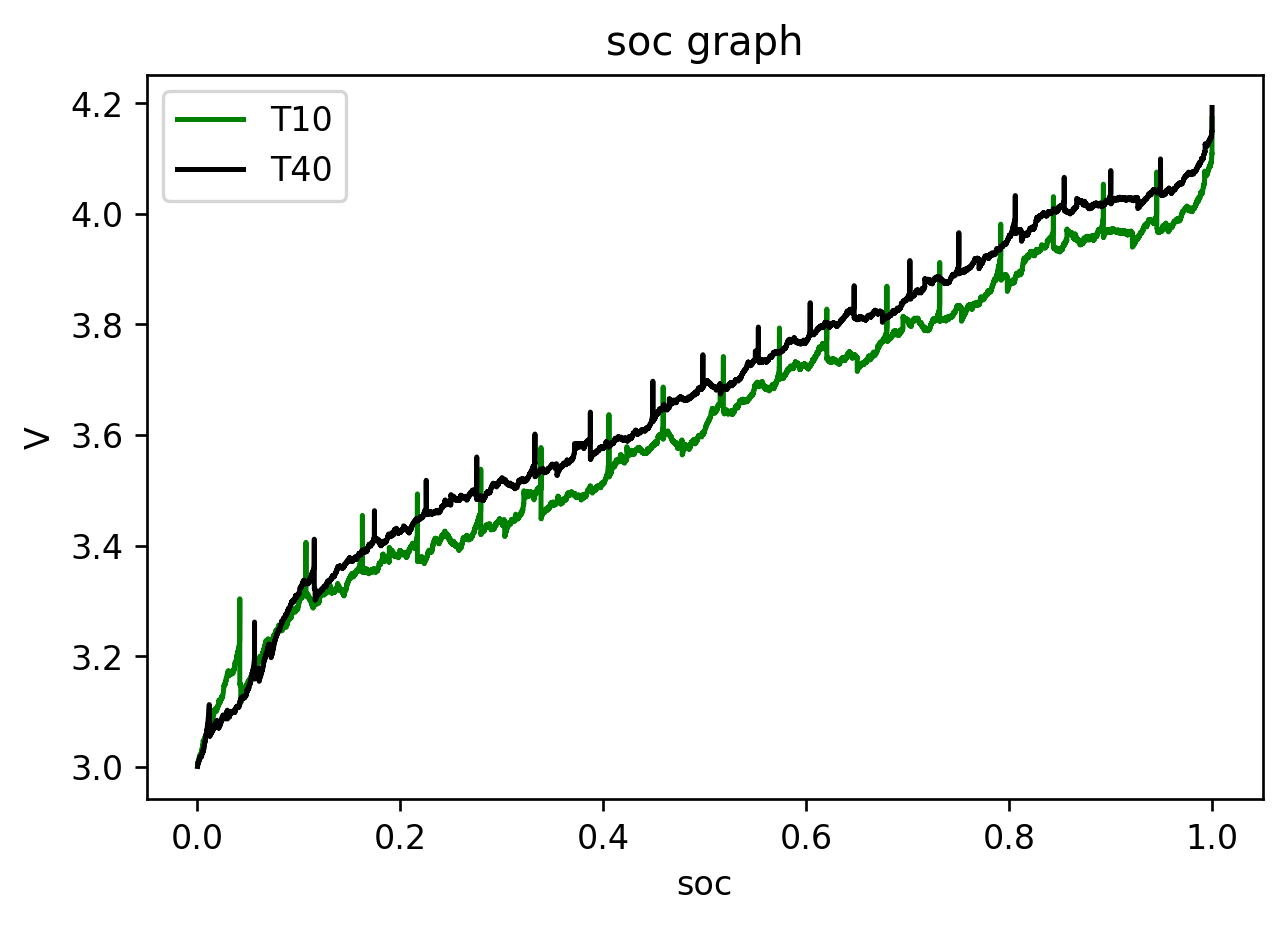

In [21]:
plt.title('soc graph')
plt.xlabel('soc')
plt.ylabel('V')
plt.plot(soc1, v1, 'g', label = 'T10')
plt.plot(soc2, v2, 'k', label = 'T40')
plt.legend()

In [22]:
import os
path = ".\DischargingData\Discharging\Real"
temp_range = ["\T10","\T15","\T20","\T25","\T30","\T35","\T40","\T45"]
temp_length = len(temp_range)
for everyt in range(temp_length) : #온도별 모든파일  
    file_list = os.listdir(path+temp_range[everyt])
    file_list_csv = [file for file in file_list if file.endswith(".csv")]
    file_length = len(file_list_csv)
    
    
    EDV = 3.0
    for k in range(file_length) : #해당온도에서 모든파일
        data = open(path+temp_range[everyt]+'\\'+file_list_csv[k], 'r')
        rdr = csv.reader(data)
        f = open(path+'\\filter_result'+temp_range[everyt]+'\\filter_result'+file_list_csv[k], 'w', newline='')
        wr = csv.writer(f)
        #--- initialize
        n = 0
        time_accum = 0.00001

        soc1 = [1]
        sysorder = 6
        t = []
        v1 = []
        I1 = []
        estimatedV = []
        fullCap1 = 4.32
        remainCap1 = [fullCap1]
        ret = []
        #--- make filters
        RLSFilter1 = RLS(sysorder)


        isFirst = 1
        i = 1
        for line in rdr:
            if isFirst == 1:
                isFirst = 0
                continue
            I_tmp = float(line[4])# 파일에서 전류값 읽기
            v_tmp = float(line[5])# 파일에서 전압값 일기
            t_tmp = float(line[2])# 파일에서 시간 읽기

            if v_tmp <= EDV : 
                print(remainCap1[n-1])
                break

            t.append(t_tmp)
            v1.append(v_tmp)
            I1.append(I_tmp/1000)

            delta_t = (t[n] - t[n - 1]) / 3600 #초를 시간으로
            if n == 0 :
                category = ["", "step", "testTime", "Amp-hr", "Amps", "Voltage", "State", "Ro", "Rp","Cp","Rdiff","Cdiff"]
                wr.writerow(category)
               
            if n < 3:
                if n > 0:
                    remainCap1.append(remainCap1[n - 1])
                    soc1.append(remainCap1[n] / fullCap1)
                n = n + 1
                continue

            remainCap1.append(remainCap1[n - 1] + (delta_t * I1[n - 1]))

            soc1.append(remainCap1[-1] / fullCap1)
            print(remainCap1[n], soc1[n])

            if(soc1[-1] < 1) :
                ocv1 = ocv[int((soc1[-1])*1000)]
            else :
                ocv1 = ocv[1000]

    
            phi1 = np.array([[ocv1, v1[n-1], v1[n-2], I1[n], I1[n-1], I1[n-2]]])


            # RLS Filtering
            [y1, theta1] = RLSFilter1.getResult(phi1, v1[n])
            # y1 이 추정된 전압
            # theta 배터리 파라미터
            
            if I_tmp != 0 : #I_tmp가 0이면 불필요한 데이터
            
                # available SOC Calculation
                Rs1 = abs((-theta1[3] - theta1[4] - theta1[5]) / theta1[0])

                # ret.append([t[-1], ocv1,y1, v1[-1], I1[-1], Rs1[0]])
                a = ( (-1*theta1[3][0])+theta1[4][0]-theta1[5][0]) /(1 + theta1[1][0] - theta1[2][0]) # a= Ro
                b = (1 + theta1[2][0] + np.sqrt(theta1[2][0]**2 + 3*theta1[2][0] - theta1[1][0])) / 2*theta1[0][0]
                r = (1 + theta1[2][0] - np.sqrt(theta1[2][0]**2 + 3*theta1[2][0] - theta1[1][0])) / 2*theta1[0][0]
                w = (theta1[5][0]-theta1[3][0]) / theta1[0][0]
                z = (-theta1[3][0] -theta1[4][0] - theta1[5][0])/theta1[0][0]
                Rp = (w-a*b-a*r-z*b+a*b)/(r-b)
                Rdiff = (z-a)-Rp
                Cp = b/Rp
                Cdiff = r/Rdiff
                line.append(a)
                line.append(Rp)
                line.append(Cp)
                line.append(Rdiff)
                line.append(Cdiff)
                wr.writerow(line)
            if (n == 10000) and (v_tmp > 4.0) :
                ex = open(path+'\\filter_result'+'\\exception.txt','a')
                ex.write(file_list_csv[k])
                ex.close()
            n = n + 1
        f.close()
        data.close()

    




4.320000363429334 1.0000000841271606
4.320000371001223 1.0000000858799127
4.320000736538501 1.0000001704950232
4.3200007439988894 1.0000001722219651
4.3200011089155 1.0000002566934028
4.320001116358111 1.0000002584162293
4.320001482562334 1.0000003431857254
4.320001490030334 1.000000344914429
4.320001862838668 1.0000004312126545
4.320001870440223 1.0000004329722738
4.320002253176501 1.0000005215686343
4.320002260984445 1.000000523376029
4.320002637342556 1.000000610495962
4.320002645016167 1.000000612272261
4.320003023827001 1.0000006999599538
4.320003031552279 1.0000007017482127
4.320003404940445 1.0000007881806585
4.320003412555557 1.0000007899434158
4.320003782165279 1.000000875501222
4.3200037897028345 1.0000008772460265
4.320004162032057 1.0000009634333464
4.320004169621724 1.0000009651902138
4.320004547144946 1.0000010525798486
4.320004554845668 1.0000010543624231
4.320004924079724 1.0000011398332693
4.3200049316096125 1.000001141576299
4.320005310232612 1.000001229220512
4.32000

4.320088897131002 1.0000205780395837
4.320088906060501 1.0000205801065976
4.320089335153502 1.0000206794336808
4.320089343904113 1.0000206814592854
4.32008977233289 1.0000207806326133
4.320089781067391 1.0000207826544885
4.3200902153516685 1.0000208831832564
4.320090228634668 1.0000208862580249
4.320090666525002 1.0000209876215282
4.320090680081335 1.000020990759568
4.320091117971669 1.0000210921230714
4.320091127005002 1.0000210942141208
4.320091563801891 1.0000211953245117
4.320091572711058 1.000021197386819
4.32009201555128 1.0000212998961295
4.320092024583336 1.0000213019868833
4.32009247737328 1.0000214067993705
4.320092491220864 1.0000214100048295
4.3200929363080585 1.0000215130342727
4.320092945490614 1.0000215151598641
4.320093394665447 1.00002161913552
4.320093403825503 1.0000216212559034
4.32009385345767 1.0000217253374235
4.320093862627503 1.00002172746007
4.32009430345328 1.000021829503074
4.320094312440003 1.000021831583334
4.320094750461892 1.0000219329772897
4.3200947638

4.320195897156309 1.0000453465639605
4.320195905909031 1.0000453485900536
4.320196330202753 1.0000454468061928
4.320196338854197 1.000045448808842
4.320196755713531 1.000045545304058
4.3201967684668645 1.0000455482562185
4.320197188226281 1.0000456454227502
4.320197196885781 1.000045647427264
4.320197623027892 1.0000457460712713
4.320197631714947 1.0000457480821636
4.3201980650028915 1.000045848380299
4.320198078257225 1.0000458514484316
4.320198506032614 1.0000459504705124
4.320198514854447 1.0000459525126033
4.3201989528355025 1.000046053897107
4.320198966228502 1.0000460569973384
4.320199398056335 1.000046156957485
4.320199406965502 1.000046159019792
4.32019984178878 1.0000462596733286
4.3201998550895295 1.0000462627522058
4.320200285990474 1.0000463624977949
4.320200294875863 1.0000463645545978
4.320200740353918 1.000046467674518
4.3202007494364185 1.0000464697769487
4.320201201104807 1.0000465743298164
4.320201210318697 1.0000465764626612
4.320201657522641 1.0000466799820926
4.320

4.3202898606101146 1.0000670973634525
4.320290279317836 1.0000671942865362
4.320290292124003 1.0000671972509265
4.320290709232086 1.0000672938037236
4.32029071783942 1.000067295796162
4.320291140763865 1.000067393695339
4.320291149389865 1.0000673956920982
4.320291581888365 1.0000674958074918
4.320291590705977 1.0000674978486057
4.320292026049199 1.0000675986224996
4.32029203492531 1.000067600677155
4.320292473488921 1.0000677021965094
4.320292482434922 1.000067704267343
4.320292928473755 1.0000678075170728
4.3202929375694215 1.0000678096225513
4.320293377524088 1.0000679114639093
4.320293386493866 1.0000679135402466
4.320293823541199 1.000068014708611
4.320293832450755 1.000068016771008
4.320294278241866 1.0000681199633947
4.320294287330754 1.0000681220673042
4.320294724606755 1.0000682232886005
4.320294733525254 1.0000682253530682
4.320295179212921 1.0000683285215093
4.320295192851921 1.0000683316786854
4.320295624574671 1.000068431614507
4.320295633475782 1.0000684336749495
4.320296

4.320386651824727 1.0000895027372052
4.3203870531891715 1.0000895956456415
4.32038706137395 1.0000895975402662
4.320387468659227 1.0000896918192654
4.320387476963949 1.0000896937416548
4.320387876627005 1.000089786256251
4.32038788477745 1.000089788142928
4.320388289155394 1.0000898817489339
4.320388297396116 1.0000898836565082
4.320388693942228 1.0000899754495896
4.3203887020235605 1.0000899773202685
4.320389088497449 1.0000900667818169
4.320389096374893 1.0000900686052994
4.32038948394856 1.000090158321426
4.320389491848894 1.0000901601502068
4.320389878739283 1.0000902497081672
4.32038988662906 1.0000902515345047
4.3203902637983935 1.0000903388422206
4.320390275329727 1.0000903415115108
4.320390657838449 1.0000904300551965
4.320390665728616 1.000090431881624
4.3203910509148935 1.000090521045114
4.320391058768227 1.0000905228630153
4.320391452823505 1.000090614079515
4.320391460860338 1.000090615939893
4.320391864552283 1.0000907093871025
4.320391872782005 1.0000907112921307
4.320392

4.320468888016256 1.0001085388926518
4.320468900112839 1.0001085416927868
4.320469300755173 1.0001086344340677
4.3204693131493395 1.0001086373030879
4.320469719649395 1.000108731400323
4.320469728030006 1.0001087333402792
4.320470144162506 1.0001088296672467
4.320470156892339 1.0001088326139673
4.32047057650895 1.0001089297474421
4.320470585153172 1.0001089317484195
4.32047100062145 1.0001090279216318
4.32047101333095 1.0001090308636458
4.3204714268203945 1.000109126578795
4.320471435347672 1.0001091285527017
4.320471862507894 1.0001092274323828
4.320471871219116 1.0001092294488694
4.320472294059171 1.0001093273285118
4.320472302679671 1.000109329323998
4.320472729300893 1.0001094280789105
4.320472738002337 1.0001094300931335
4.320473155400671 1.0001095267131181
4.320473163913949 1.0001095286837844
4.320473592070504 1.0001096277940982
4.320473600798671 1.0001096298145071
4.320474018801337 1.0001097265743835
4.320474027328171 1.0001097285481877
4.320474453636337 1.0001098272306335
4.320

4.320554456423891 1.0001283463944193
4.320554468833891 1.0001283492671045
4.3205548692687525 1.0001284419603593
4.320554877527697 1.000128443872152
4.320555283421919 1.000128537829148
4.320555291697809 1.0001285397448632
4.320555701517476 1.0001286346105267
4.320555709874753 1.0001286365450817
4.320556123742365 1.0001287323477694
4.320556132185698 1.0001287343022447
4.320556555815198 1.0001288323646291
4.320556564455643 1.000128834364732
4.320556983724143 1.0001289314176256
4.320556992273865 1.0001289333967278
4.320557412413476 1.0001290306512676
4.320557420980142 1.0001290326342922
4.320557837964698 1.0001291291584948
4.3205578464648084 1.000129131126113
4.3205582723591975 1.000129229712777
4.32055828104242 1.0001292317227823
4.320558714744142 1.0001293321166995
4.320558723586309 1.0001293341634974
4.320559151723809 1.0001294332694002
4.32055916045792 1.0001294352911851
4.3205595825085314 1.000129532988086
4.320559591116754 1.00012953498073
4.320560021309531 1.0001296345623916
4.32056

4.320633838857572 1.000146721957771
4.320633847277183 1.0001467239067552
4.320634266379627 1.0001468209212099
4.320634274926349 1.0001468228996178
4.320634686488238 1.0001469181685736
4.320634694881571 1.0001469201114748
4.320635116496627 1.0001470177075524
4.320635125093404 1.0001470196975473
4.320635553791682 1.0001471189332596
4.32063556253296 1.0001471209567037
4.320635991582405 1.0001472202737047
4.320636000330905 1.0001472222988204
4.320636436381904 1.0001473232365519
4.320636445273682 1.0001473252948339
4.320636882487071 1.0001474265016368
4.320636891403016 1.0001474285655128
4.320637332936571 1.0001475307723544
4.3206373419402375 1.0001475328565363
4.320637786713237 1.0001476358132493
4.3206378003173205 1.0001476389623427
4.320638238517515 1.0001477403975727
4.3206382475563485 1.0001477424898955
4.320638681925015 1.0001478430381978
4.3206386907832925 1.0001478450887251
4.320639117799237 1.0001479439350085
4.320639126504959 1.000147945950222
4.320639548639959 1.0001480436666572


4.320720692137932 1.0001668268837807
4.320720699655988 1.0001668286240712
4.3207210708854324 1.000166914556813
4.320721078453932 1.0001669163087805
4.320721440836154 1.000167000193554
4.320721448231265 1.0001670019053854
4.3207218022834875 1.0001670838619183
4.320721809505654 1.0001670855337161
4.320722172364265 1.000167169528765
4.320722179763599 1.0001671712415736
4.320722535062599 1.0001672534867125
4.3207225423047095 1.000167255163127
4.320722899204376 1.0001673377787905
4.320722906482487 1.0001673394635386
4.320723266994543 1.0001674229154034
4.32072327434132 1.0001674246160464
4.320723642227876 1.0001675097749714
4.320723649729821 1.0001675115115327
4.320724007998765 1.0001675944441586
4.320724015307821 1.0001675961360696
4.320724367013487 1.0001676775494184
4.320724374183932 1.0001676792092435
4.320724723834321 1.0001677601468335
4.320724730958599 1.0001677617959719
4.3207250708688765 1.0001678404789065
4.320725077797765 1.000167842082816
4.320725411975043 1.0001679194386672
4.3

4.3208189917756705 1.0001895814295534
4.320819001463892 1.0001895836721972
4.320819466944837 1.0001896914224158
4.320819476435948 1.0001896936194323
4.320819931801115 1.0001897990280357
4.3208199457313645 1.0001898022526305
4.32082039731217 1.0001899067852245
4.3208204066269476 1.000189908941423
4.320820868245058 1.0001900157974672
4.320820877655225 1.0001900179757466
4.320821342948336 1.0001901256824852
4.320821352439447 1.0001901278795016
4.320821814327058 1.00019023479793
4.3208218237452805 1.0001902369780742
4.320822295996392 1.0001903462954609
4.320822310441558 1.0001903496392495
4.32082277949853 1.0001904582172523
4.320822789170641 1.0001904604561669
4.320823261193086 1.0001905697206217
4.320823270819419 1.0001905719489395
4.320823747347141 1.0001906822562827
4.320823757065863 1.0001906845059867
4.320824239639641 1.0001907962128798
4.3208242494800295 1.0001907984907474
4.320824724992363 1.000190908563047
4.32082473468903 1.0001909108076457
4.320825220730918 1.000191023317342
4.32

4.320900555151613 1.000208461840651
4.320900555173835 1.0002084618457951
4.320900555173835 1.0002084618457951
4.320900555173835 1.0002084618457951
4.320900555196057 1.000208461850939
4.320900555218279 1.0002084618560831
4.320900555218279 1.0002084618560831
4.320900555218279 1.0002084618560831
4.3209005552405015 1.0002084618612272
4.3209005552405015 1.0002084618612272
4.3209005552405015 1.0002084618612272
4.3209005552405015 1.0002084618612272
4.3209005552405015 1.0002084618612272
4.320900555262724 1.0002084618663711
4.320900555262724 1.0002084618663711
4.320900555262724 1.0002084618663711
4.320900555284946 1.0002084618715152
4.320900555307168 1.0002084618766593
4.320900555307168 1.0002084618766593
4.32090055532939 1.0002084618818032
4.32090055532939 1.0002084618818032
4.320900555351613 1.0002084618869473
4.320900555351613 1.0002084618869473
4.320900555351613 1.0002084618869473
4.320900555351613 1.0002084618869473
4.320900555351613 1.0002084618869473
4.320900555373835 1.0002084618920914


4.321001013647694 1.0002317161221514
4.321001517364972 1.000231832723373
4.321001527638527 1.000231835101511
4.321002039598694 1.0002319536108089
4.32100205526586 1.0002319572374676
4.3210025535333045 1.0002320725771539
4.321002568944304 1.0002320761445147
4.321003070973193 1.0002321923549056
4.321003081326415 1.000232194751485
4.321003580783415 1.0002323103665312
4.321003596059582 1.000232313902681
4.321004100125471 1.0002324305845998
4.32100411051686 1.0002324329900139
4.321004613567193 1.0002325494368502
4.321004623827193 1.0002325518118502
4.321005119339693 1.0002326665138177
4.321005134498277 1.0002326700227493
4.321005621726583 1.0002327828070792
4.321005631772527 1.0002327851325294
4.321006115925194 1.000232897204906
4.321006130729027 1.0002329006317192
4.321006600359916 1.000233009342573
4.321006610046416 1.0002330115848184
4.321007087967915 1.000233122214795
4.321007097714193 1.000233124470878
4.3210075840664155 1.000233237052411
4.321007593984804 1.0002332393483342
4.32100808

4.321121105800747 1.0002595152316542
4.321121115559302 1.0002595174905793
4.3211215962629135 1.0002596287645633
4.321121606066414 1.000259631033892
4.321122091359691 1.0002597433702989
4.321122101253469 1.0002597456605251
4.321122582101357 1.0002598569679066
4.321122591912468 1.0002598592389973
4.3211230807990795 1.0002599724071943
4.321123090775524 1.0002599747165564
4.3211235720616905 1.0002600861253912
4.321123581877468 1.000260088397562
4.321124069413857 1.0002602012532076
4.3211240793585235 1.0002602035552137
4.321124567934802 1.0002603166515744
4.32112457789808 1.0002603189578887
4.321125060221413 1.0002604306068086
4.321125070055413 1.0002604328831974
4.321125547955136 1.0002605435081333
4.321125557699691 1.0002605457638174
4.321126029368247 1.0002606549463533
4.321126038986914 1.0002606571728967
4.321126500436247 1.000260763989872
4.321126509843024 1.0002607661673666
4.321126976320302 1.0002608741482182
4.321126985830913 1.0002608763497485
4.321127456584803 1.0002609853205562
4

4.32120270593766 1.0002784041522361
4.321202716226493 1.0002784065339103
4.321203227127715 1.000278524798082
4.32120323754666 1.000278527209875
4.321203756029272 1.000278647228998
4.321203766602105 1.0002786496764131
4.32120428315466 1.000278769248764
4.321204293692271 1.0002787716880257
4.321204807378327 1.0002788905968347
4.321204817854493 1.0002788930218733
4.32120532996166 1.000279011565199
4.321205340406882 1.0002790139830746
4.3212058443501045 1.0002791306365981
4.3212058546308825 1.0002791330164078
4.321206362439661 1.0002792505647362
4.3212063779784105 1.000279254161669
4.321206872422438 1.0002793686163052
4.321206882618438 1.0002793709764901
4.321207377197216 1.0002794854623185
4.321207387285105 1.0002794877974779
4.321207884479938 1.0002796028888745
4.321207894625938 1.0002796052374856
4.321208394978549 1.0002797210598493
4.321208405183882 1.000279723422195
4.321208897870716 1.000279837470073
4.3212089079171045 1.000279839795626
4.32120941109266 1.000279956271449
4.3212094213

4.321293649017742 1.0002994557911438
4.321293980121631 1.0002995324355626
4.321293986875853 1.00029953399904
4.321294316585964 1.0002996103208248
4.3212943233084085 1.0002996118769463
4.3212946638611305 1.000299690708595
4.3212946742716305 1.000299693118433
4.321295002139713 1.0002997690138224
4.321295008902824 1.0002997705793575
4.321295330595991 1.0002998450453682
4.321295337153157 1.0002998465632307
4.321295663272657 1.0002999220538558
4.321295669919213 1.0002999235924104
4.3212959896197125 1.0002999975971556
4.321295996137435 1.0002999991058876
4.321296320947546 1.0003000742934134
4.321296327569546 1.0003000758262837
4.321296648391601 1.0003001500906483
4.321296654934768 1.0003001516052703
4.321296975340323 1.000300225773223
4.321296981873712 1.0003002272855814
4.3212973111482675 1.0003003035065434
4.321297317859267 1.0003003050600154
4.321297651143656 1.0003003822091796
4.321297657938156 1.0003003837819804
4.321297992695267 1.0003004612720525
4.321297999517323 1.000300462851232
4.

4.32136537077804 1.0003160580504722
4.321365790773374 1.0003161552716142
4.321365799337929 1.0003161572541501
4.321366224295874 1.0003162556240448
4.321366232964707 1.0003162576307192
4.321366663282707 1.0003163572413674
4.321366672057485 1.000316359272566
4.321367098741318 1.0003164580419717
4.3213671074410955 1.000316460055809
4.321367529222207 1.0003165576903257
4.321367537829151 1.000316559682674
4.321367956847207 1.0003166566775943
4.32136796539054 1.0003166586552177
4.321368388606262 1.0003167566218198
4.321368397236096 1.0003167586194666
4.3213688226731515 1.0003168571002665
4.321368831347929 1.0003168591083167
4.321369249660929 1.0003169559400298
4.321369262455596 1.0003169589017582
4.32136968673629 1.0003170571148818
4.321369695488179 1.0003170591407822
4.32137011795529 1.0003171569340947
4.321370126567734 1.0003171589277162
4.321370551193567 1.000317257220733
4.321370559850512 1.0003172592246554
4.321370988028845 1.0003173583400105
4.321370996756179 1.0003173603602264
4.32137

4.321458628702085 1.0003376455328898
4.321459137381974 1.0003377632828643
4.321459152938558 1.0003377668839253
4.321459652070919 1.0003378824238238
4.321459662361863 1.0003378848059867
4.321460169296808 1.0003380021520387
4.3214601848006415 1.0003380057408893
4.321460689604808 1.0003381225937056
4.321460705223058 1.0003381262090412
4.321461200098197 1.0003382407634713
4.32146121030353 1.0003382431258172
4.321461707623586 1.0003383582462004
4.321461717770419 1.0003383605950045
4.321462208649697 1.0003384742244668
4.321462223659447 1.000338477698946
4.321462715780863 1.0003385916159406
4.321462725928086 1.0003385939648346
4.3214632232889745 1.00033870909467
4.321463233433252 1.0003387114428823
4.321463733845752 1.0003388272791092
4.321463749153085 1.0003388308224732
4.3214642389923075 1.0003389442111823
4.321464249095919 1.0003389465499812
4.321464748678141 1.000339062194014
4.321464758868641 1.000339064552926
4.3214652679432515 1.000339182394271
4.321465278324919 1.0003391847974348
4.32

4.32156502712183 1.0003622747967198
4.321565036595552 1.0003622769897111
4.321565497048552 1.0003623835760538
4.321565511132635 1.000362386836258
4.321565959981275 1.0003624907364062
4.321565969237552 1.0003624928790629
4.321566418788052 1.0003625969416787
4.32156642795533 1.0003625990637337
4.3215668703817745 1.0003627014772625
4.321566879400274 1.000362703564878
4.321567319292329 1.0003628053917428
4.321567328260385 1.0003628074676816
4.321567765326774 1.0003629086404568
4.321567774238885 1.0003629107034455
4.321568219945608 1.000363013876298
4.321568229031941 1.000363015979616
4.3215686674485525 1.0003631174649426
4.321568676384386 1.0003631195334226
4.321569111147775 1.0003632201730959
4.321569120011164 1.0003632222248064
4.321569555250941 1.0003633229747548
4.321569564126164 1.0003633250292046
4.321569994237275 1.0003634245919617
4.3215700030048305 1.0003634266214885
4.321570434526053 1.0003635265106603
4.321570443326275 1.0003635285477488
4.321570872231441 1.0003636278313521
4.32

4.321644891074616 1.0003807618228278
4.321644898267116 1.0003807634877582
4.32164524384506 1.0003808434826527
4.321645250892171 1.0003808451139284
4.321645607416171 1.000380927642632
4.321645614684115 1.0003809293250265
4.321645975528282 1.000381012853769
4.321645982885227 1.0003810145567653
4.3216463470940605 1.0003810988643658
4.321646354518005 1.0003811005828713
4.321646710960338 1.0003811830926708
4.321646721858421 1.0003811856153753
4.32164708120031 1.000381268796368
4.321647088611088 1.0003812705118258
4.321647454066699 1.0003813551080323
4.321647461525422 1.0003813568345883
4.3216478359126445 1.0003814434982972
4.321647843548089 1.0003814452657611
4.321648216146811 1.0003815315154656
4.3216482237437 1.0003815332740045
4.3216485989611995 1.0003816201299072
4.3216486066148665 1.0003816219015893
4.321648973856256 1.0003817069111702
4.321648981343756 1.000381708644388
4.321649352654867 1.000381794596034
4.321649360223756 1.0003817963480914
4.321649735356867 1.0003818831844598
4.3216

4.321765448809619 1.0004086687059301
4.321765455416341 1.0004086702352641
4.321765786498452 1.0004087468746417
4.321765793245508 1.00040874843646
4.321766134255563 1.0004088273739729
4.3217661412102855 1.0004088289838624
4.321766472395841 1.0004089056471854
4.321766479147508 1.0004089072100713
4.321766807591786 1.0004089832388392
4.3217668142845636 1.0004089847880933
4.321767147381119 1.0004090618937775
4.321767154172675 1.0004090634658969
4.321767487851786 1.000409140706432
4.321767494653897 1.0004091422809946
4.321767839257285 1.0004092220502974
4.321767846281952 1.0004092236763777
4.321768191922508 1.0004093036857655
4.321768198968341 1.0004093053167455
4.321768539439397 1.0004093841294899
4.321768546378452 1.0004093857357528
4.32176887945323 1.0004094628363958
4.321768886249841 1.0004094644096855
4.321769226448675 1.0004095431594153
4.321769233382231 1.0004095447644052
4.321769571463175 1.000409623023883
4.321769578352175 1.000409624618559
4.321769906069619 1.0004097004790784
4.321

4.321828112587787 1.000423174210136
4.321828515054731 1.0004232673737803
4.321828523257731 1.000423269272623
4.321828915837565 1.0004233601475845
4.321828923839676 1.000423361999925
4.321829327324731 1.0004234553992433
4.321829335551453 1.000423457303577
4.321829743770453 1.000423551798716
4.321829752090842 1.000423553724732
4.3218301593135084 1.000423647989238
4.321830167613564 1.0004236499105472
4.321830576809842 1.0004237446319078
4.321830585152286 1.000423746563029
4.321830986663731 1.0004238395054932
4.321830994851064 1.0004238414007092
4.321831400244397 1.0004239352417585
4.3218314085101195 1.0004239371551202
4.321831811183952 1.0004240303666556
4.321831819391175 1.0004240322664757
4.321832227547564 1.0004241267471212
4.3218322358692305 1.000424128673433
4.321832635488731 1.0004242211779468
4.321832643634508 1.0004242230635434
4.32183305006773 1.0004243171453078
4.321833058354675 1.000424319063582
4.321833464581008 1.0004244130974556
4.321833472863286 1.0004244150146495
4.3218338

4.321941183347314 1.0004493479970633
4.32194152919748 1.0004494280549723
4.321941536248869 1.0004494296872382
4.321941888161425 1.000449511148478
4.321941895336147 1.0004495128092932
4.321942240728981 1.0004495927613382
4.321942251294564 1.0004495952070749
4.3219425968408975 1.000449675194652
4.321942603970231 1.000449676844961
4.321942956860064 1.0004497585324221
4.321942964053842 1.0004497601976485
4.321943320681286 1.0004498427502977
4.321943327956897 1.000449844434467
4.321943681883897 1.000449926362013
4.321943689097175 1.0004499280317534
4.321944048572064 1.0004500112435333
4.3219440559006195 1.000450012939958
4.321944416910842 1.0004500965071392
4.321944424270342 1.0004500982107272
4.321944783826897 1.0004501814414113
4.321944791152897 1.0004501831372448
4.321945153472508 1.0004502670075248
4.321945160860008 1.0004502687175945
4.321945517571842 1.0004503512897782
4.3219455248423415 1.0004503529727642
4.32194587407623 1.0004504338139422
4.321945881198397 1.0004504354625918
4.3219

4.322014209377788 1.0004662521707843
4.322014218208121 1.0004662542148428
4.322014654278177 1.0004663551569852
4.322014663168677 1.0004663572149715
4.32201510675751 1.0004664598975717
4.32201511580101 1.0004664619909744
4.322015554925399 1.0004665636401386
4.322015563880733 1.0004665657131324
4.322016003086788 1.0004666673812008
4.322016016522955 1.0004666704914247
4.322016456345205 1.0004667723021308
4.322016465416705 1.000466774402015
4.322016913263094 1.0004668780701607
4.322016926960594 1.0004668812408781
4.322017377310039 1.000466985488435
4.3220173865968725 1.0004669876381649
4.322017846698706 1.0004670941432188
4.3220178560795945 1.0004670963147209
4.322018313957372 1.0004672023049472
4.322018323293372 1.0004672044660583
4.322018782251872 1.000467310706452
4.32201879161115 1.0004673128729513
4.322019251421706 1.00046741931058
4.322019260798372 1.0004674214811047
4.322019721708705 1.0004675281733113
4.32201973110615 1.0004675303486457
4.322020199494427 1.000467638771858
4.3220202

4.322117273299067 1.0004901095599692
4.322117720230789 1.0004902130163864
4.322117733904789 1.000490216181664
4.322118167335817 1.0004903165129204
4.322118176274206 1.000490318581992
4.322118618907539 1.0004904210434118
4.32211862793115 1.0004904231322107
4.322119079120428 1.0004905275741731
4.322119088322039 1.0004905297041757
4.322119538909706 1.0004906340068764
4.322119548100317 1.0004906361343326
4.322119999229706 1.000490740562432
4.322120008429206 1.0004907426919456
4.322120451851983 1.0004908453361072
4.322120460896761 1.0004908474298058
4.322120896386983 1.0004909482377276
4.322120909714483 1.000490951322797
4.322121333216483 1.0004910493556674
4.322121341949316 1.0004910513771563
4.322121771850816 1.0004911508913925
4.322121780620927 1.0004911529215108
4.322122212599482 1.0004912529165468
4.322122221409427 1.0004912549558858
4.322122643002705 1.0004913525469223
4.322122651596927 1.0004913545363256
4.322123071134927 1.0004914516516032
4.322123079690593 1.0004914536320817
4.3221

4.3222158782500975 1.0005129347801152
4.322216414304653 1.0005130588668176
4.3222164252407085 1.000513061398312
4.322216967420264 1.0005131869028387
4.322216978480486 1.0005131894630754
4.322217516195598 1.000513313934166
4.322217527166431 1.0005133164737108
4.322218070780598 1.0005134423103235
4.3222180818683755 1.0005134448769386
4.322218629367153 1.0005135716127669
4.322218634951959 1.0005135729055459
4.322219189107209 1.000513701182224
4.322219194810264 1.000513702502376
4.322219742857764 1.0005138293652232
4.322219748495125 1.0005138306701677
4.322220306951375 1.000513959942448
4.322220312700431 1.0005139612732477
4.3222208660581805 1.0005140893653195
4.322220871749597 1.000514090682777
4.322221432763347 1.000514220547071
4.322221444307235 1.0005142232192674
4.322222018369458 1.000514356104041
4.322222030078236 1.0005143588144063
4.322222615023903 1.000514494218496
4.322222632923986 1.0005144983620338
4.322223205361403 1.000514630870695
4.322223217171458 1.000514633604504
4.322223

4.322337790755008 1.0005411552673629
4.322337790755008 1.0005411552673629
4.322337790755008 1.0005411552673629
4.322337790755008 1.0005411552673629
4.3223377907772305 1.000541155272507
4.3223377907772305 1.000541155272507
4.3223377907772305 1.000541155272507
4.3223377907772305 1.000541155272507
4.3223377907772305 1.000541155272507
4.3223377907772305 1.000541155272507
4.3223377907772305 1.000541155272507
4.3223377907772305 1.000541155272507
4.3223382532065635 1.0005412623163341
4.322338262838842 1.000541264546028
4.322338743645897 1.0005413758439576
4.322338753454508 1.0005413781144694
4.322339222964342 1.0005414867973013
4.322339237333258 1.0005414901234393
4.3223397111593975 1.0005415998054161
4.322339720934064 1.0005416020680702
4.322340203755564 1.0005417138323065
4.322340213601453 1.0005417161114474
4.3223406934339526 1.0005418271837851
4.322340703220897 1.0005418294492816
4.32234118589812 1.0005419411801202
4.3223411957465645 1.0005419434598528
4.322341681725843 1.0005420559550562

4.322445956239899 1.0005661935740506
4.322445963949955 1.0005661953587857
4.3224463363417875 1.000566281560599
4.3224463439340095 1.0005662833180577
4.322446712547398 1.000566368645231
4.322446720060342 1.0005663703843384
4.32244709610812 1.000566457432435
4.322447103773675 1.0005664592068693
4.322447489749398 1.0005665485531012
4.322447501555398 1.0005665512859716
4.322447887456425 1.0005666406149132
4.322447895417814 1.0005666424578272
4.322448283448814 1.000566732279818
4.322448291361036 1.0005667341113509
4.322448675031036 1.000566822923851
4.322448682852536 1.0005668247343833
4.322449063615203 1.0005669128738894
4.32244907137737 1.0005669146706873
4.322449457954703 1.0005670041561812
4.322449465836425 1.000567005980654
4.32244984715987 1.0005670942499698
4.322449854934314 1.0005670960496098
4.322450235468314 1.0005671841361838
4.322450243227537 1.0005671859323
4.322450614206537 1.0005672718070686
4.322450621771203 1.0005672735581488
4.322450997674704 1.000567360572848
4.3224510053

4.322540430374182 1.0005880625866161
4.322540438660682 1.0005880645047875
4.322540855062682 1.0005881608941394
4.322540863554738 1.000588162859893
4.322541286291349 1.00058826071559
4.3225412949084605 1.0005882627102918
4.322541716523516 1.0005883603063694
4.322541729426266 1.0005883632931172
4.322542149616794 1.000588460559443
4.322542162616878 1.0005884635687217
4.322542579724961 1.0005885601215185
4.322542588328905 1.0005885621131725
4.322543019997127 1.000588662036372
4.322543028798627 1.0005886640737562
4.322543460319849 1.000588763962928
4.322543469118794 1.0005887659997208
4.322543898625572 1.000588865422586
4.322543911767405 1.000588868464677
4.322544347911738 1.0005889694240133
4.322544356903516 1.0005889715054435
4.322544794013461 1.000589072688301
4.322544802929405 1.000589074752177
4.322545242987516 1.0005891766174806
4.322545251958572 1.000589178694114
4.32254569469535 1.0005892811794792
4.322545703723184 1.0005892832692553
4.322546140520073 1.0005893843796465
4.3225461494

4.322620675875629 1.0006066379341734
4.322620686963407 1.0006066405007885
4.322621228729185 1.0006067659095335
4.322621239779685 1.0006067684675195
4.322621771285407 1.0006068915012516
4.322621787541991 1.0006068952643496
4.322622319667824 1.0006070184416258
4.322622330641157 1.0006070209817493
4.322622878346824 1.0006071477654683
4.322622883932907 1.0006071490585433
4.322623433974157 1.0006072763829066
4.322623439635685 1.0006072776934456
4.322623993810185 1.00060740597458
4.322623999513463 1.000607407294783
4.322624550918714 1.0006075349348873
4.322624562263769 1.0006075375610577
4.322625111050158 1.000607664594944
4.322625122246881 1.0006076671867778
4.322625667439936 1.000607793388874
4.322625678559103 1.000607795962755
4.322626223106991 1.000607922015507
4.3226262286595745 1.0006079233008274
4.322626778973074 1.0006080506882116
4.322626784638185 1.00060805199958
4.322627346597935 1.0006081820828552
4.322627352380269 1.0006081834213585
4.3226279037442685 1.000608311051914
4.3226279

4.322747025668598 1.0006358855714346
4.322747517879042 1.0006359995090375
4.3227475279194865 1.0006360018332143
4.322748030076931 1.0006361180733636
4.322748040319542 1.0006361204443384
4.32274854580082 1.0006362374538935
4.322748556107876 1.0006362398397861
4.322749059076543 1.000636356267718
4.3227490693344315 1.0006363586422296
4.32274957446182 1.0006364755698658
4.322749589914737 1.0006364791469298
4.3227500821600975 1.000636593092615
4.322750092308208 1.000636595441715
4.322750601132375 1.0006367132250868
4.322750611513597 1.0006367156281475
4.322751129081541 1.000636835435542
4.322751139638652 1.0006368378793176
4.32275165261693 1.0006369566242892
4.322751668308929 1.0006369602566965
4.322752184133374 1.000637079660503
4.3227521947702074 1.000637082122733
4.32275270554893 1.0006372003585484
4.3227527211665135 1.00063720397373
4.322753225375208 1.0006373206887054
4.3227532357610965 1.0006373230928463
4.322753736590096 1.000637439025485
4.322753746805596 1.0006374413901842
4.322754

4.322852836377076 1.0006603787909898
4.322853391434326 1.0006605072764643
4.322853397142048 1.0006605085976963
4.322853957130048 1.0006606382245482
4.322853962892437 1.0006606395584345
4.322854522269937 1.0006607690439668
4.3228545280240755 1.0006607703759434
4.322855099278826 1.0006609026108393
4.322855111036326 1.0006609053324826
4.322855694443937 1.000661040380541
4.322855706342159 1.000661043134759
4.32285629670777 1.0006611797934652
4.322856308756437 1.0006611825825085
4.32285690537227 1.0006613206880255
4.3228569175426035 1.0006613235052322
4.322857505166937 1.0006614595293835
4.322857511161187 1.0006614609169413
4.3228575112250756 1.0006614609317304
4.3228575112250756 1.0006614609317304
4.3228575112250756 1.0006614609317304
4.3228575112250756 1.0006614609317304
4.3228575112250756 1.0006614609317304
4.3228575112250756 1.0006614609317304
4.3228575112250756 1.0006614609317304
4.322857511247298 1.0006614609368745
4.32285751126952 1.0006614609420184
4.322857511291742 1.00066146094716

4.32295734474279 1.0006845705423124
4.322957865032956 1.0006846909798508
4.322957875642623 1.0006846934357922
4.322958385964012 1.0006848115657434
4.3229583963719564 1.0006848139749898
4.322958902933957 1.0006849312347121
4.3229589184371235 1.0006849348234081
4.322959430602513 1.0006850533802112
4.322959441165568 1.0006850558253628
4.32295995302229 1.0006851743107152
4.322959963461568 1.000685176727215
4.322960485766179 1.00068529763106
4.322960496419957 1.0006853000972122
4.322961018912402 1.0006854210445373
4.322961029569124 1.0006854235113714
4.322961540990291 1.0006855418959006
4.322961551419847 1.0006855443101497
4.322962073827902 1.0006856652379403
4.322962084483347 1.0006856677044784
4.32296259804418 1.0006857865843009
4.322962608520791 1.0006857890094423
4.322963115684402 1.0006859064084264
4.322963126025346 1.0006859088021633
4.32296362295068 1.0006860238311759
4.3229636330856245 1.000686026177228
4.32296412535868 1.0006861401293239
4.322964135397013 1.0006861424530122
4.32296

4.323082398163742 1.0007135180934588
4.323082855627742 1.0007136239879033
4.323082864956076 1.0007136261472398
4.32308333159941 1.00071373416653
4.323083341112965 1.0007137363687417
4.323083802605854 1.0007138431957996
4.323083812015576 1.000713845373976
4.323084283621521 1.0007139545420185
4.323084298047688 1.000713957881409
4.3230847659110205 1.0007140661831064
4.323084775564465 1.0007140684177
4.323085257762576 1.0007141800376331
4.323085267594909 1.0007141823136363
4.323085741299686 1.0007142919675198
4.323085750957353 1.0007142942030909
4.323086229521297 1.0007144049817818
4.323086239284519 1.0007144072417868
4.323086709583797 1.0007145161073603
4.323086719176186 1.0007145183278208
4.323087183949353 1.000714625914202
4.323087193426075 1.0007146281078878
4.323087656122186 1.0007147352134689
4.323087665559464 1.0007147373980239
4.323088128775519 1.0007148446239627
4.323088138218742 1.0007148468098939
4.323088597925853 1.000714953223577
4.32308861198577 1.0007149564781874
4.323089054

4.323196630374935 1.0007399607349385
4.323197222548101 1.0007400978120604
4.323197234628156 1.0007401006083694
4.323197816810768 1.000740235372863
4.323197828686546 1.0007402381218855
4.32319841533099 1.0007403739192104
4.323198989973045 1.000740506938205
4.32319899583674 1.0007405082955416
4.32319955714474 1.000740638227949
4.3231995686902955 1.0007406409005313
4.323200146179795 1.0007407745786563
4.323200152070407 1.0007407759422238
4.323200714954157 1.0007409062393882
4.323200720739657 1.0007409075786242
4.323201280746908 1.0007410372099323
4.323201286507825 1.0007410385434778
4.3232018489075745 1.0007411687286052
4.32320185469413 1.0007411700680855
4.32320241159663 1.0007412989807012
4.323202417325547 1.0007413003068395
4.323202969382547 1.0007414280978117
4.323202975059547 1.0007414294119321
4.3232035382347975 1.0007415597765734
4.323203544030881 1.0007415611182595
4.323204113542131 1.0007416929495672
4.323204125262742 1.0007416956626718
4.3232047040589086 1.0007418296432657
4.323

4.323297590154747 1.0007633310543393
4.323297598945191 1.0007633330891645
4.323298026042803 1.0007634319543524
4.323298034752748 1.0007634339705433
4.323298460252414 1.0007635324658366
4.323298468930137 1.0007635344745687
4.323298882070914 1.000763630109008
4.323298890496415 1.0007636320593551
4.323299298984915 1.0007637266168783
4.323299307313359 1.000763728544759
4.323299724360526 1.000763825083455
4.323299732863193 1.000763827051665
4.323300154500026 1.0007639246527837
4.32330016310147 1.0007639266438586
4.32330058141447 1.0007640234755717
4.323300589945526 1.0007640254503531
4.323301012910804 1.0007641233589823
4.323301021540638 1.000764125356629
4.3233014355743045 1.0007642211977557
4.323301444018916 1.0007642231525267
4.323301854108083 1.0007643180805748
4.323301866652916 1.0007643209844712
4.323302279360972 1.0007644165187435
4.32330228787425 1.0007644184894096
4.32330270045425 1.0007645139940393
4.323302708866639 1.0007645159413516
4.323303118727139 1.0007646108164674
4.3233031

4.323424122187195 1.0007926208766653
4.323424131600306 1.0007926230556263
4.323424592012473 1.0007927296325168
4.3234246013989175 1.000792731805305
4.323425070886973 1.0007928404830955
4.323425080461584 1.0007928426994408
4.3234255622649735 1.000792954228003
4.323425572089251 1.0007929565021414
4.323426054496974 1.0007930681705957
4.323426064334362 1.000793070447769
4.323426537187085 1.0007931799044176
4.323426551655168 1.000793183253511
4.323427031317474 1.0007932942864521
4.3234270412070295 1.0007932965757012
4.323427515992529 1.0007934064797521
4.323427525672696 1.0007934087205315
4.323428010342585 1.0007935209126355
4.323428020225752 1.0007935232004055
4.323428506038974 1.0007936356571698
4.323428515945474 1.000793637950341
4.323428998538307 1.000793749661645
4.323429008380807 1.0007937519400016
4.323429495149529 1.0007938646179466
4.323429505074252 1.000793866915336
4.3234299978236965 1.0007939809777076
4.323430007875975 1.0007939833046238
4.323430496471308 1.0007940964053952
4.32

4.3235103335098 1.0008125772013425
4.323510341550022 1.0008125790625049
4.323510742312855 1.0008126718316794
4.323510750482355 1.0008126737227674
4.323511149002077 1.000812765972703
4.3235111571266325 1.0008127678533871
4.323511566341966 1.0008128625791588
4.323511574682744 1.0008128645098944
4.323511982610466 1.0008129589376078
4.3235119950866325 1.0008129618256094
4.323512387793827 1.0008130527300525
4.323512395892105 1.0008130546046539
4.323512780871494 1.0008131437202532
4.3235127887222715 1.0008131455375628
4.323513180741327 1.0008132362827145
4.32351319273491 1.0008132390590068
4.323513588195826 1.0008133306008857
4.323513596353049 1.0008133324891315
4.323514001395216 1.0008134262488926
4.323514009652049 1.0008134281601966
4.323514418826549 1.0008135228765158
4.323514427167716 1.0008135248073415
4.323514832043827 1.0008136185286636
4.323514840299827 1.0008136204397748
4.323515244468161 1.0008137139972595
4.323515252710161 1.0008137159051298
4.323515659516327 1.0008138100732238
4.

4.323617902159427 1.000837477351719
4.323617902159427 1.000837477351719
4.323617902181649 1.0008374773568631
4.323617902181649 1.0008374773568631
4.323617902181649 1.0008374773568631
4.323617902203871 1.0008374773620072
4.323617902203871 1.0008374773620072
4.323617902226093 1.0008374773671511
4.323617902226093 1.0008374773671511
4.323617902226093 1.0008374773671511
4.323617902248316 1.0008374773722952
4.323617902270538 1.0008374773774393
4.32361790229276 1.0008374773825832
4.323617902314982 1.0008374773877273
4.323617902314982 1.0008374773877273
4.323617902315871 1.0008374773879332
4.323618362305205 1.0008375838669457
4.323618371889149 1.0008375860854513
4.323618844886149 1.0008376955754974
4.323618854537927 1.0008376978097053
4.323619319292038 1.0008378053916753
4.32361932877426 1.0008378075866342
4.323619792134593 1.0008379148459705
4.323619801587538 1.0008379170341521
4.323620267961371 1.000838024991058
4.323620277479205 1.0008380271942603
4.323620737371427 1.0008381336507932
4.3236

4.323690514558618 1.0008542857774578
4.3236905246740625 1.000854288118996
4.323691027163618 1.0008544044360226
4.323691037412174 1.0008544068083736
4.3236915459042295 1.000854524514868
4.323691561457646 1.0008545281151957
4.32369207107409 1.0008546460819652
4.323692081582035 1.00085464851436
4.323692599544701 1.0008547684131253
4.323692610107757 1.000854770858277
4.323693123856423 1.0008548897815794
4.32369313957134 1.0008548934192916
4.323693657203757 1.0008550132416103
4.323693667875312 1.0008550157118776
4.323694192109978 1.000855137062495
4.3236942028018674 1.0008551395374692
4.323694732644312 1.0008552621861833
4.32369474345109 1.0008552646877522
4.323695285568034 1.0008553901777855
4.323695296629534 1.000855392738318
4.323695843066645 1.00085551922839
4.323695848640839 1.0008555205187126
4.323696396352839 1.0008556473038979
4.323696407627562 1.0008556499137875
4.323696950640118 1.0008557756111383
4.323696961716451 1.0008557781751044
4.323697502651951 1.0008559033916553
4.32369751

4.323806772968151 1.0008811974463312
4.323807237368373 1.0008813049463827
4.323807246836151 1.0008813071379978
4.3238077149549285 1.000881415498826
4.323807724501151 1.0008814177085996
4.323808190292429 1.0008815255306547
4.3238081997924285 1.0008815277297287
4.323808662322484 1.0008816347968712
4.323808671753428 1.00088163697996
4.323809146601539 1.0008817468985043
4.323809156285094 1.0008817491400679
4.323809637405205 1.0008818605104641
4.323809652126955 1.0008818639182766
4.323810116207288 1.0008819713442796
4.323810125775955 1.0008819735592487
4.323810591921122 1.0008820814632227
4.323810601429622 1.0008820836642642
4.323811077813066 1.0008821939382098
4.323811087530955 1.000882196187721
4.3238115740927885 1.000882308817775
4.323811588976039 1.0008823122629718
4.323812059326344 1.0008824211403573
4.323812069027677 1.0008824233860363
4.323812533697399 1.000882530948472
4.323812543173677 1.0008825331420548
4.323813002608566 1.0008826394927235
4.32381301198101 1.000882641662271
4.3238

4.323888092528339 1.000900021418597
4.323888106215672 1.000900024586961
4.323888545380478 1.0009001262454809
4.323888554440534 1.0009001283427161
4.323889008724978 1.0009002335011523
4.323889022620229 1.0009002367176454
4.323889478027145 1.0009003421359133
4.3238894874203675 1.0009003443102702
4.323889938424534 1.0009004487093829
4.323889952219284 1.0009004519026121
4.323890409865284 1.000900557839186
4.323890419303395 1.000900560023934
4.3238908905581726 1.000900669110688
4.323890900171784 1.000900671336061
4.323891372256839 1.000900780615009
4.323891386704589 1.0009007839593955
4.323891855575645 1.000900892494362
4.3238918652447556 1.0009008947325821
4.3238923393633115 1.000901004482248
4.3238923490349785 1.0009010067210597
4.323892824462923 1.0009011167738247
4.323892834157478 1.0009011190179347
4.323893315027145 1.0009012303303575
4.3238933248353115 1.0009012326007665
4.323893816983145 1.000901346523876
4.323893827021867 1.0009013488476544
4.323894309865144 1.0009014606169315
4.323

KeyboardInterrupt: 

In [23]:
f.close()

In [ ]:
df = pd.DataFrame(ret, columns = ["time", "ocv1", "estV1", "voltage", "I1", "R1"])

In [22]:
print(df)

           time     ocv1     estV1  voltage        I1         R1
0      13363.67  4.17205  0.000000  4.10842  0.001363   0.000653
1      13363.69  4.17205  4.009764  4.10933  0.001343   0.000859
2      13364.67  4.17205  4.057367  4.10674  0.001343   0.000923
3      13364.69  4.17205  4.073123  4.10674  0.001341   0.000955
4      13365.67  4.17205  4.080616  4.10521  0.001340   0.000973
5      13365.69  4.17205  4.085003  4.10506  0.001345   0.000985
6      13366.67  4.17205  4.087777  4.10338  0.001344   0.000993
7      13366.69  4.17205  4.089394  4.10231  0.001369   0.001000
8      13367.67  4.17205  4.090098  4.10109  0.001368   0.001006
9      13367.69  4.17205  4.090562  4.09926  0.001406   0.001012
10     13368.67  4.17205  4.090426  4.09773  0.001405   0.001017
11     13368.69  4.17205  4.089982  4.09834  0.001383   0.001023
12     13369.67  4.17205  4.090374  4.09758  0.001381   0.001027
13     13369.69  4.17205  4.090877  4.09743  0.001392   0.001030
14     13370.67  4.17205 

In [9]:
df["estI1"]=-(df["ocv1"]-df["voltage"])/df["R1"]
df["estI2"]=-(df["ocv2"]-df["voltage"])/df["R2"]
df["estI3"]=-(df["ocv3"]-df["voltage"])/df["R3"]

In [10]:
print(df)

          time     ocv1     ocv2     ocv3     estV1     estV2     estV3  \
0       2148.0  4.17205  4.17205  4.17205  0.000000  0.000000  0.000000   
1       2149.0  4.17205  4.17205  4.17205  4.091593  4.091593  4.091593   
2       2150.0  4.17205  4.17205  4.17205  4.130424  4.130424  4.130424   
3       2151.0  4.17205  4.17205  4.17205  4.143533  4.143533  4.143532   
4       2152.0  4.17205  4.17205  4.17205  4.150118  4.150118  4.150118   
...        ...      ...      ...      ...       ...       ...       ...   
13904  16052.0  3.30320  3.28962  3.29145  3.347921  3.347898  3.347866   
13905  16053.0  3.30320  3.28962  3.29145  3.347922  3.347898  3.347868   
13906  16054.0  3.30320  3.28962  3.29145  3.347922  3.347899  3.347868   
13907  16055.0  3.30320  3.28962  3.29145  3.347923  3.347900  3.347869   
13908  16056.0  3.30320  3.28962  3.29145  3.347923  3.347900  3.347872   

       voltage       I1       I2       I3        R1        R2        R3  \
0         4.17  0.00477 